In [2]:
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
import pandas as pd
import sys
sys.path.append('../../')
from models.MLP.MLP import MLP
from models.AutoEncoders.AutoEncoders import AutoEncoders as AE
from models.knn.knn import KNN
from models.AutoEncoders.cnn_autoencoder import CNN_AE
from models.pca.pca import PCA
from models.AutoEncoders.pca_auto import PCA_AE



In [3]:
# Custom DataLoader class
class DataLoader:
    def __init__(self, images, labels, batch_size=32, shuffle=True):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(images))
        self.current_index = 0

        if shuffle:
            np.random.shuffle(self.indices)

    def __iter__(self):
        self.current_index = 0
        if self.shuffle:
            np.random.shuffle(self.indices)
        return self

    def __next__(self):
        if self.current_index >= len(self.images):
            raise StopIteration

        batch_indices = self.indices[self.current_index:self.current_index + self.batch_size]
        batch_images = self.images[batch_indices]
        batch_labels = self.labels[batch_indices]
        self.current_index += self.batch_size

        return batch_images, batch_labels

In [ ]:
train_df = pd.read_csv('../data/interim/fashion-mnist_train.csv')
test_df = pd.read_csv('../data/interim/fashion-mnist_test.csv')

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)


train_data = train_df.iloc[:50000]  
val_data = train_df.iloc[50000:]    


train_labels = train_data.iloc[:, 0].values  
train_features = train_data.iloc[:, 1:].values / 255.0  

val_labels = val_data.iloc[:, 0].values
val_features = val_data.iloc[:, 1:].values / 255.0

test_labels = test_df.iloc[:, 0].values
test_features = test_df.iloc[:, 1:].values / 255.0


train_features_tensor = torch.tensor(train_features, dtype=torch.float32).reshape(-1, 1, 28, 28)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)

val_features_tensor = torch.tensor(val_features, dtype=torch.float32).reshape(-1, 1, 28, 28)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)

test_features_tensor = torch.tensor(test_features, dtype=torch.float32).reshape(-1, 1, 28, 28)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)




train_loader = DataLoader(train_features_tensor, train_labels_tensor, batch_size=64, shuffle=True)
val_loader = DataLoader(val_features_tensor, val_labels_tensor, batch_size=64, shuffle=False)
test_loader = DataLoader(test_features_tensor, test_labels_tensor, batch_size=64, shuffle=False)


for batch_images, batch_labels in train_loader:
    print("Batch images shape:", batch_images.shape)
    print("Batch labels shape:", batch_labels.shape)
    break  


Batch images shape: torch.Size([64, 1, 28, 28])
Batch labels shape: torch.Size([64])


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


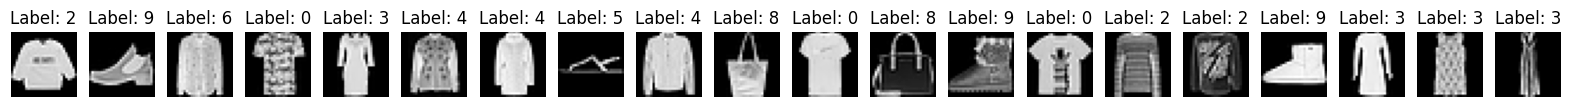

In [ ]:
data = pd.read_csv('fashion-mnist_train.csv')

labels = data.iloc[:, 0]           
images = data.iloc[:, 1:].values    


def visualize_samples(images, labels, num_samples=10):
    plt.figure(figsize=(20, 20))
    for i in range(num_samples):
        
        image = images[i].reshape(28, 28)  
        label = labels[i]

        
        plt.subplot(1, num_samples, i+1)
        plt.imshow(image, cmap='gray')
        plt.title(f'Label: {label}')
        plt.axis('off')

    plt.show()


visualize_samples(images, labels, num_samples=20)


List of Types of Clothes:
1) Shoes
2) Handbags
3) T-shirts
4) Shirts
5) Skirt
6) Pant
7) Sneaker
8) Sandal
9) Coat



In [7]:
def predict(model, loss_fn, data_loader):
    model.eval()
    tot_loss = 0
    total_batches = 0
    predictions = []
    true_values = []

    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            reconstructed = model(images)
            loss = loss_fn(reconstructed, images)
            tot_loss += loss.item()
            total_batches += 1
            predictions.append(reconstructed.detach().cpu().numpy())
            true_values.append(images.detach().cpu().numpy())

    tot_loss /= total_batches
    predictions = np.concatenate(predictions, axis=0)
    true_values = np.concatenate(true_values, axis=0)

    return tot_loss, predictions, true_values

def fit(model,loss_fn,optimizer,num_epochs,train_loader,val_loader):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        total_batches = 0
        for images, _ in train_loader:
            images = images.to(device)
            # Forward pass
            reconstructed = model(images)
            loss = loss_fn(reconstructed, images)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            total_batches += 1

        train_loss /= total_batches
        val_loss,_,_ = predict(model,loss_fn,val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    return train_losses,val_losses

In [8]:
def plot_losses(label, num_epoch, train_losses, val_losses):
    epochs = list(range(1, num_epoch + 1))  # Generate a list of epochs
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label=label + ' Train')
    plt.plot(epochs, val_losses, label=label + ' Val')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Number of Epochs')
    plt.legend()
    plt.show()

def visualise_samples(y_true, y_pred, num_samples=10):
    image_shape = (28, 28)

    fig, axes = plt.subplots(2, num_samples, figsize=(20, 4))
    for i in range(num_samples):
        # Original images
        axes[0, i].imshow(y_true[i].reshape(image_shape), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")

        # Reconstructed images
        axes[1, i].imshow(y_pred[i].reshape(image_shape), cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title("Reconstructed")

    plt.suptitle("Original and Reconstructed Images")
    plt.show()

Epoch [1/10], Train Loss: 0.0033, Validation Loss: 0.0003
Epoch [2/10], Train Loss: 0.0003, Validation Loss: 0.0002
Epoch [3/10], Train Loss: 0.0002, Validation Loss: 0.0002
Epoch [4/10], Train Loss: 0.0002, Validation Loss: 0.0001
Epoch [5/10], Train Loss: 0.0001, Validation Loss: 0.0001
Epoch [6/10], Train Loss: 0.0001, Validation Loss: 0.0001
Epoch [7/10], Train Loss: 0.0001, Validation Loss: 0.0000
Epoch [8/10], Train Loss: 0.0001, Validation Loss: 0.0000
Epoch [9/10], Train Loss: 0.0000, Validation Loss: 0.0000
Epoch [10/10], Train Loss: 0.0000, Validation Loss: 0.0000


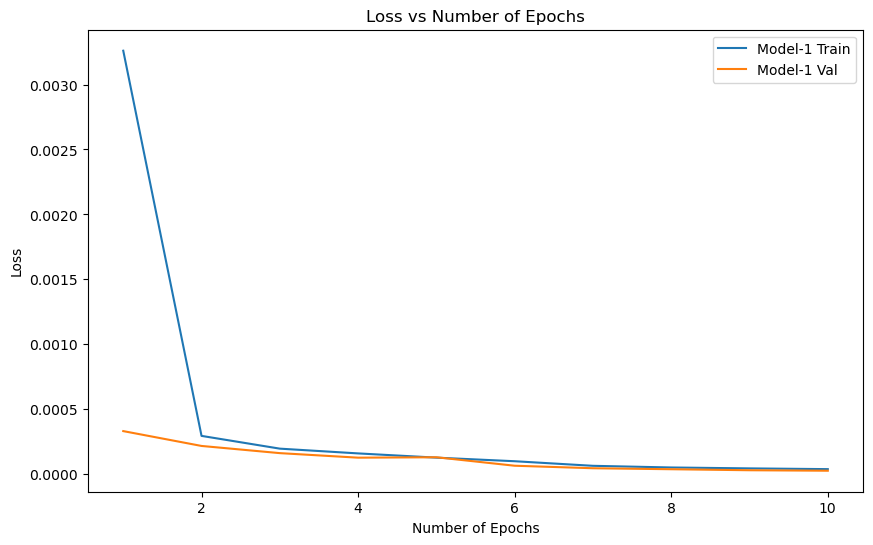

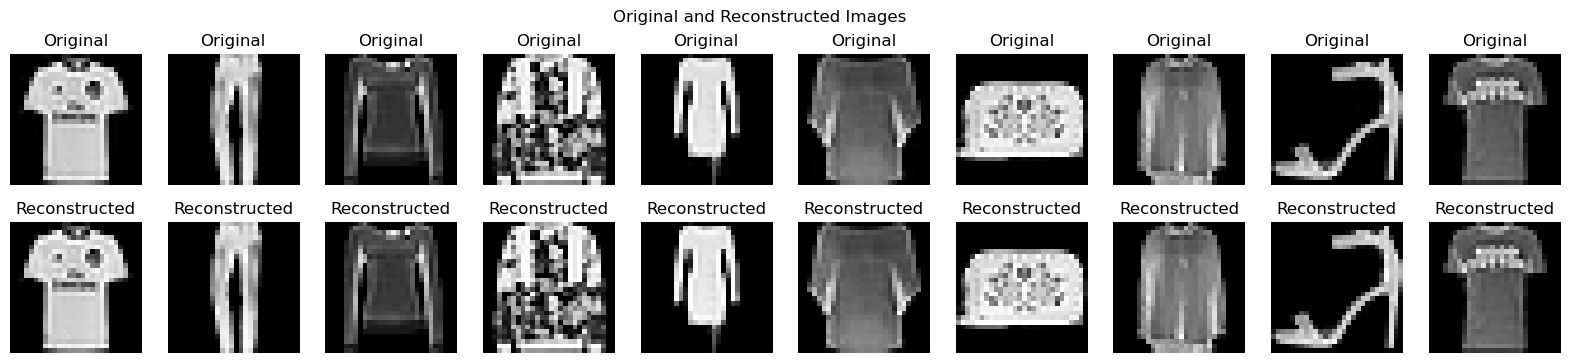

In [ ]:


# Initialize the autoencoder, loss function, and optimizer
model = CNN_AE(in_channels=1, channel_list=[16,32])  # Customize as needed
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epoch = 10
train_losses,val_losses = fit(model,loss_fn,optimizer,num_epochs=num_epoch,train_loader=train_loader,val_loader=val_loader)
plot_losses('Model-1',num_epoch=num_epoch,train_losses=train_losses,val_losses=val_losses)

# Run predict and visualize
_, y_pred, y_true = predict(model, loss_fn, test_loader)
visualise_samples(y_true, y_pred, num_samples=10)



Epoch [1/10], Train Loss: 0.1092, Validation Loss: 0.0930
Epoch [2/10], Train Loss: 0.0793, Validation Loss: 0.0677
Epoch [3/10], Train Loss: 0.0587, Validation Loss: 0.0514
Epoch [4/10], Train Loss: 0.0456, Validation Loss: 0.0409
Epoch [5/10], Train Loss: 0.0371, Validation Loss: 0.0339
Epoch [6/10], Train Loss: 0.0313, Validation Loss: 0.0291
Epoch [7/10], Train Loss: 0.0272, Validation Loss: 0.0257
Epoch [8/10], Train Loss: 0.0243, Validation Loss: 0.0232
Epoch [9/10], Train Loss: 0.0221, Validation Loss: 0.0213
Epoch [10/10], Train Loss: 0.0204, Validation Loss: 0.0198


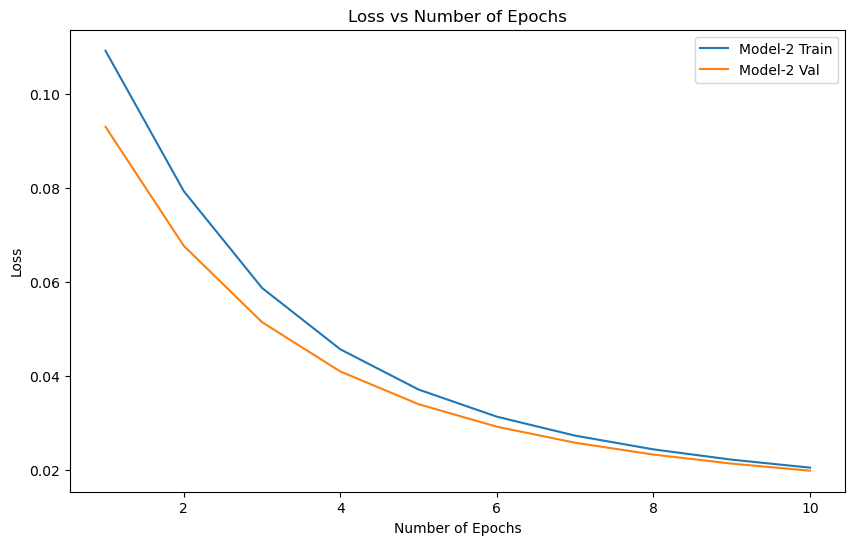

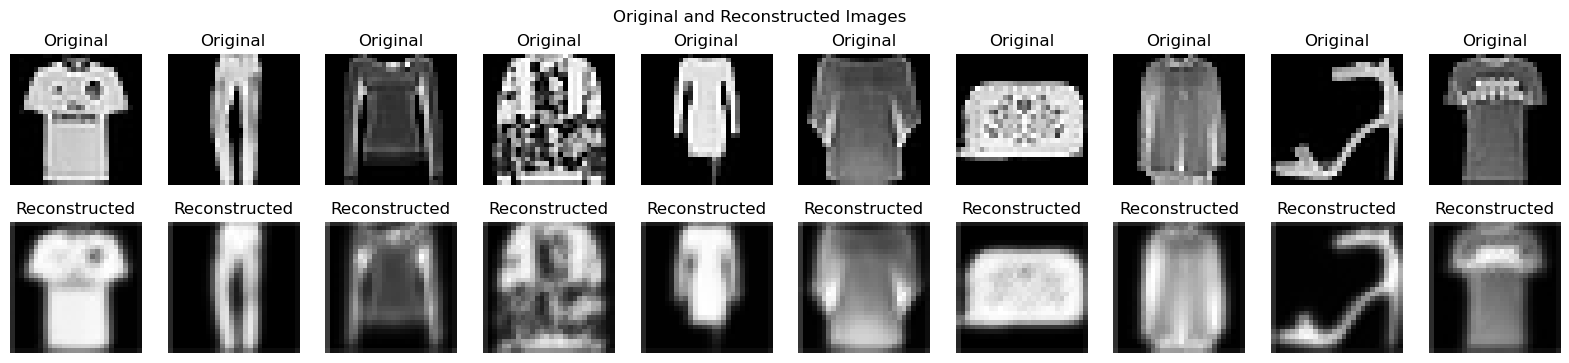

In [ ]:
model = CNN_AE(in_channels=1, channel_list=[16])  # Customize as needed
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
num_epoch = 10
train_losses,val_losses = fit(model,loss_fn,optimizer,num_epochs=num_epoch,train_loader=train_loader,val_loader=val_loader)
plot_losses('Model-2',num_epoch=num_epoch,train_losses=train_losses,val_losses=val_losses)

# Run predict and visualize
_, y_pred, y_true = predict(model, loss_fn, test_loader)
visualise_samples(y_true, y_pred, num_samples=10)


Epoch [1/10], Train Loss: 0.1254, Validation Loss: 0.1013
Epoch [2/10], Train Loss: 0.0502, Validation Loss: 0.0279
Epoch [3/10], Train Loss: 0.0256, Validation Loss: 0.0245
Epoch [4/10], Train Loss: 0.0233, Validation Loss: 0.0220
Epoch [5/10], Train Loss: 0.0204, Validation Loss: 0.0186
Epoch [6/10], Train Loss: 0.0165, Validation Loss: 0.0145
Epoch [7/10], Train Loss: 0.0130, Validation Loss: 0.0121
Epoch [8/10], Train Loss: 0.0116, Validation Loss: 0.0112
Epoch [9/10], Train Loss: 0.0108, Validation Loss: 0.0105
Epoch [10/10], Train Loss: 0.0102, Validation Loss: 0.0099


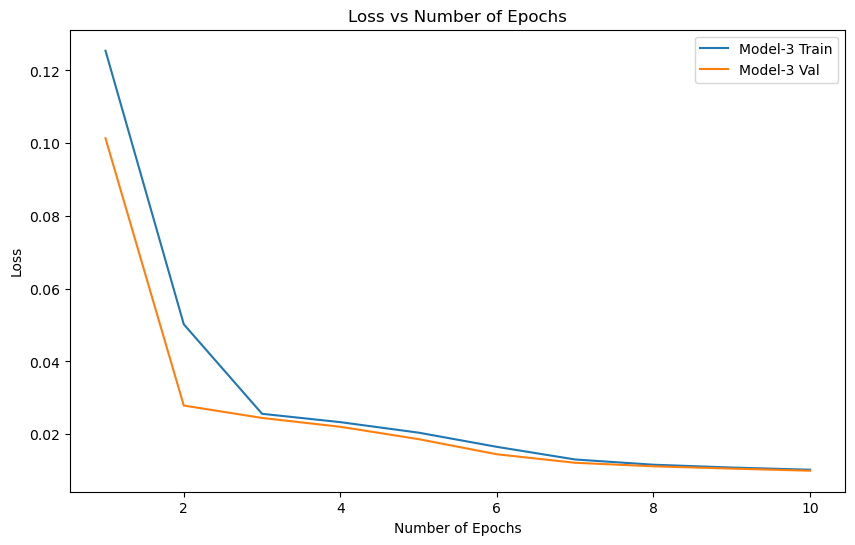

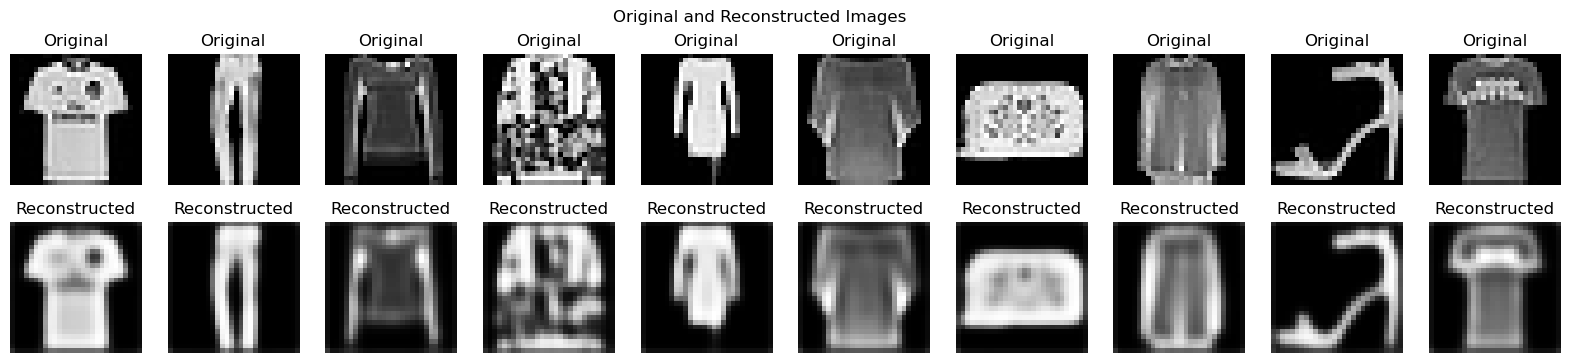

In [ ]:
model = CNN_AE(in_channels=1, channel_list=[8,16,32,64])  # Customize as needed
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
num_epoch = 10
train_losses,val_losses = fit(model,loss_fn,optimizer,num_epochs=num_epoch,train_loader=train_loader,val_loader=val_loader)
plot_losses('Model-3',num_epoch=num_epoch,train_losses=train_losses,val_losses=val_losses)

# Run predict and visualize
_, y_pred, y_true = predict(model, loss_fn, test_loader)
visualise_samples(y_true, y_pred, num_samples=10)

Epoch [1/10], Train Loss: 0.1589, Validation Loss: 0.1378
Epoch [2/10], Train Loss: 0.1183, Validation Loss: 0.1017
Epoch [3/10], Train Loss: 0.0870, Validation Loss: 0.0749
Epoch [4/10], Train Loss: 0.0647, Validation Loss: 0.0565
Epoch [5/10], Train Loss: 0.0497, Validation Loss: 0.0443
Epoch [6/10], Train Loss: 0.0398, Validation Loss: 0.0362
Epoch [7/10], Train Loss: 0.0332, Validation Loss: 0.0309
Epoch [8/10], Train Loss: 0.0287, Validation Loss: 0.0271
Epoch [9/10], Train Loss: 0.0256, Validation Loss: 0.0244
Epoch [10/10], Train Loss: 0.0233, Validation Loss: 0.0225


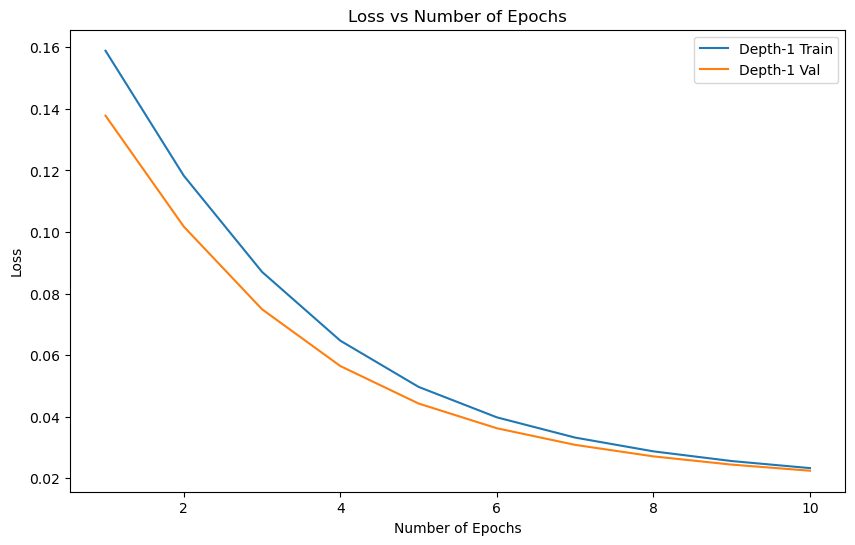

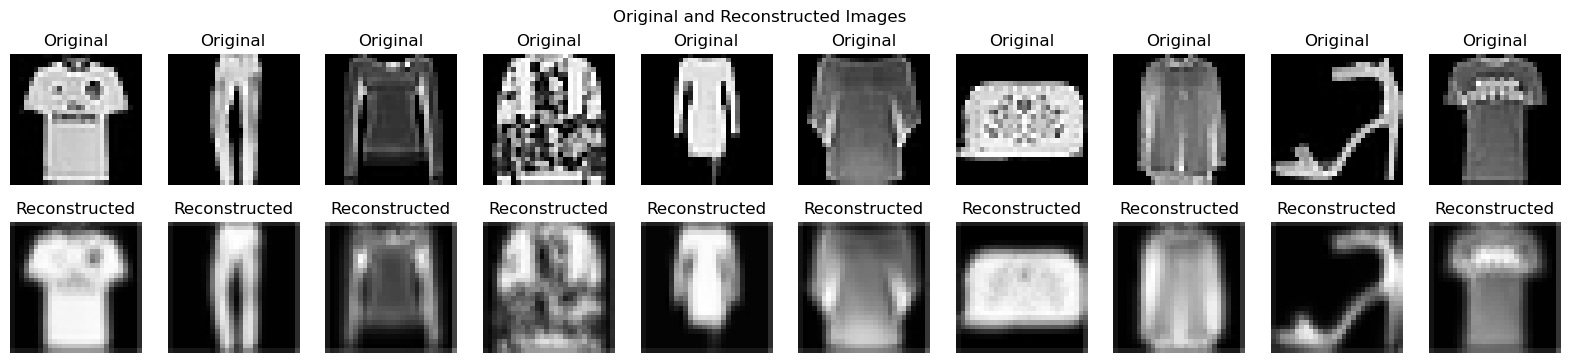

In [ ]:
# depth = 1
model = CNN_AE(in_channels=1, channel_list=[16])  # Customize as needed
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
num_epoch = 10
train_losses,val_losses = fit(model,loss_fn,optimizer,num_epochs=num_epoch,train_loader=train_loader,val_loader=val_loader)
plot_losses('Depth-1',num_epoch=num_epoch,train_losses=train_losses,val_losses=val_losses)

# Run predict and visualize
_, y_pred, y_true = predict(model, loss_fn, test_loader)
visualise_samples(y_true, y_pred, num_samples=10)


Epoch [1/10], Train Loss: 0.1445, Validation Loss: 0.1343
Epoch [2/10], Train Loss: 0.1290, Validation Loss: 0.1267
Epoch [3/10], Train Loss: 0.1220, Validation Loss: 0.1187
Epoch [4/10], Train Loss: 0.1083, Validation Loss: 0.0939
Epoch [5/10], Train Loss: 0.0723, Validation Loss: 0.0573
Epoch [6/10], Train Loss: 0.0481, Validation Loss: 0.0413
Epoch [7/10], Train Loss: 0.0361, Validation Loss: 0.0324
Epoch [8/10], Train Loss: 0.0296, Validation Loss: 0.0276
Epoch [9/10], Train Loss: 0.0260, Validation Loss: 0.0250
Epoch [10/10], Train Loss: 0.0242, Validation Loss: 0.0236


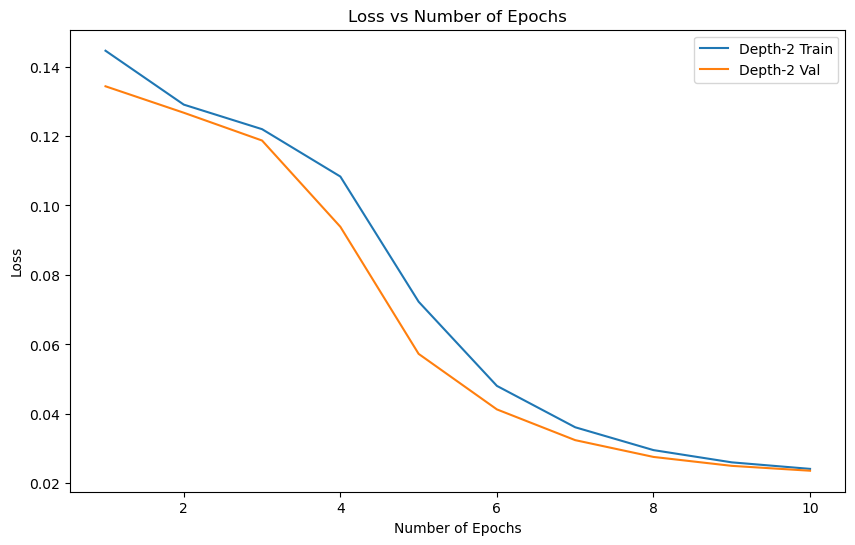

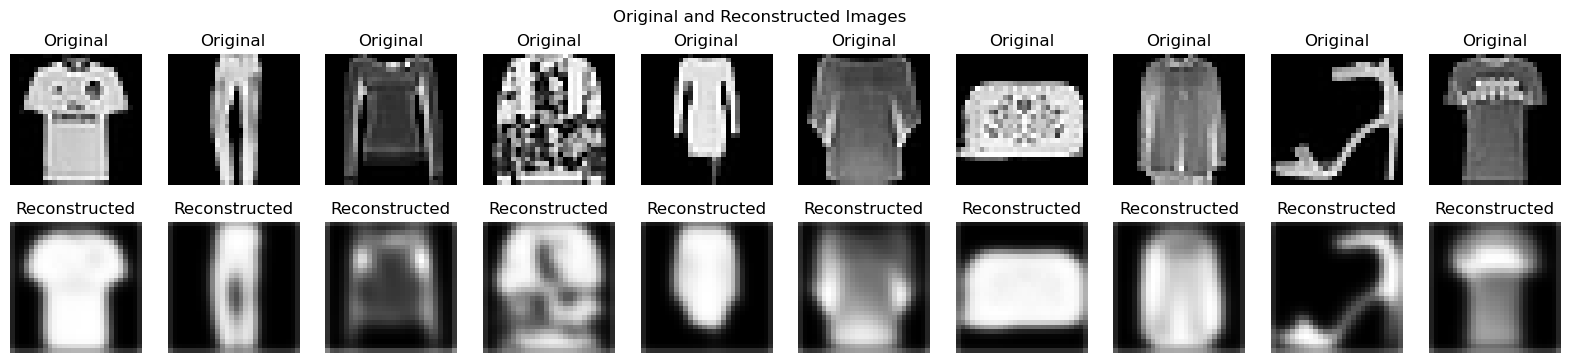

In [ ]:
model = CNN_AE(in_channels=1, channel_list=[8,16])  # Customize as needed
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
num_epoch = 10
train_losses,val_losses = fit(model,loss_fn,optimizer,num_epochs=num_epoch,train_loader=train_loader,val_loader=val_loader)
plot_losses('Depth-2',num_epoch=num_epoch,train_losses=train_losses,val_losses=val_losses)

# Run predict and visualize
_, y_pred, y_true = predict(model, loss_fn, test_loader)
visualise_samples(y_true, y_pred, num_samples=10)


Epoch [1/10], Train Loss: 0.1583, Validation Loss: 0.1508
Epoch [2/10], Train Loss: 0.1441, Validation Loss: 0.1397
Epoch [3/10], Train Loss: 0.1346, Validation Loss: 0.1316
Epoch [4/10], Train Loss: 0.1268, Validation Loss: 0.1240
Epoch [5/10], Train Loss: 0.1184, Validation Loss: 0.1139
Epoch [6/10], Train Loss: 0.1033, Validation Loss: 0.0929
Epoch [7/10], Train Loss: 0.0805, Validation Loss: 0.0725
Epoch [8/10], Train Loss: 0.0661, Validation Loss: 0.0620
Epoch [9/10], Train Loss: 0.0576, Validation Loss: 0.0550
Epoch [10/10], Train Loss: 0.0513, Validation Loss: 0.0489


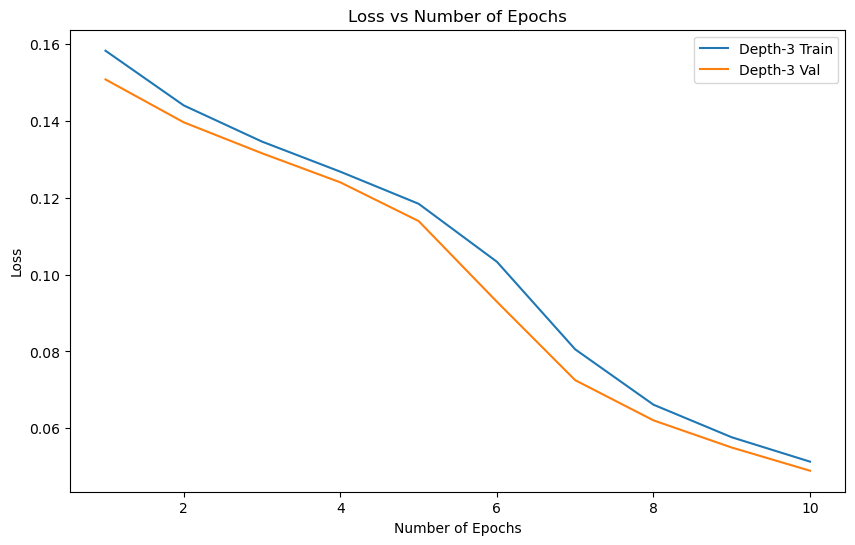

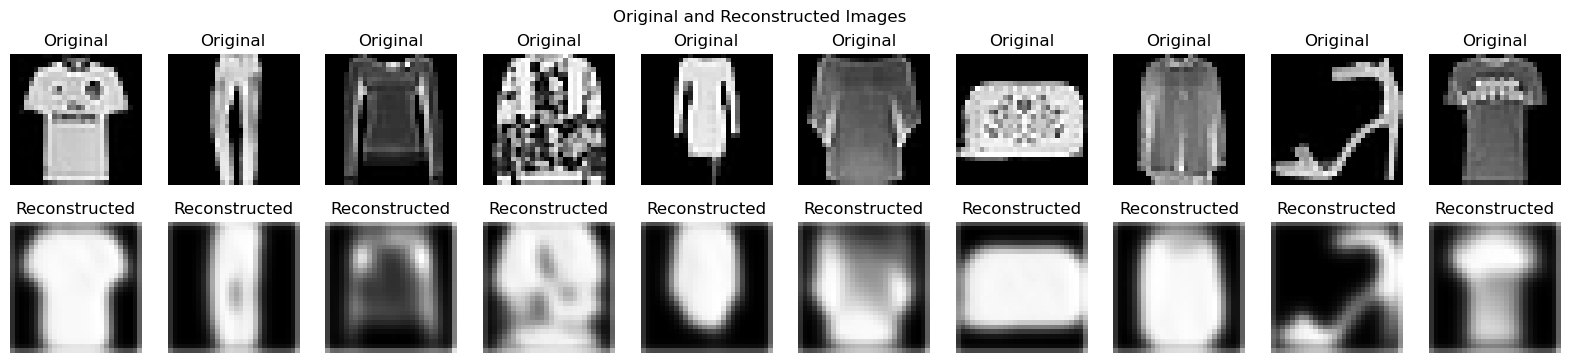

In [ ]:
model = CNN_AE(in_channels=1, channel_list=[8,16,32])  # Customize as needed
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
num_epoch = 10
train_losses,val_losses = fit(model,loss_fn,optimizer,num_epochs=num_epoch,train_loader=train_loader,val_loader=val_loader)
plot_losses('Depth-3',num_epoch=num_epoch,train_losses=train_losses,val_losses=val_losses)

# Run predict and visualize
_, y_pred, y_true = predict(model, loss_fn, test_loader)
visualise_samples(y_true, y_pred, num_samples=10)


Epoch [1/10], Train Loss: 0.0074, Validation Loss: 0.0003
Epoch [2/10], Train Loss: 0.0003, Validation Loss: 0.0001
Epoch [3/10], Train Loss: 0.0001, Validation Loss: 0.0001
Epoch [4/10], Train Loss: 0.0001, Validation Loss: 0.0001
Epoch [5/10], Train Loss: 0.0001, Validation Loss: 0.0001
Epoch [6/10], Train Loss: 0.0001, Validation Loss: 0.0001
Epoch [7/10], Train Loss: 0.0001, Validation Loss: 0.0000
Epoch [8/10], Train Loss: 0.0000, Validation Loss: 0.0001
Epoch [9/10], Train Loss: 0.0000, Validation Loss: 0.0001
Epoch [10/10], Train Loss: 0.0000, Validation Loss: 0.0000


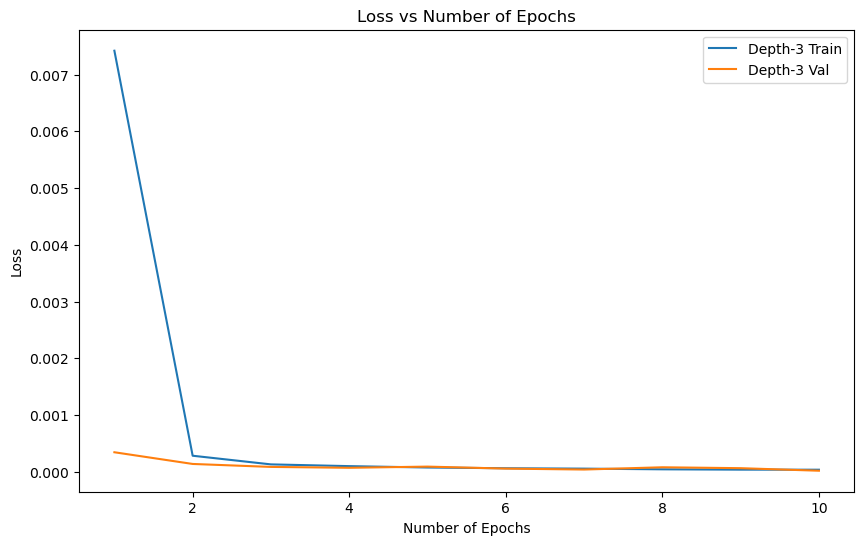

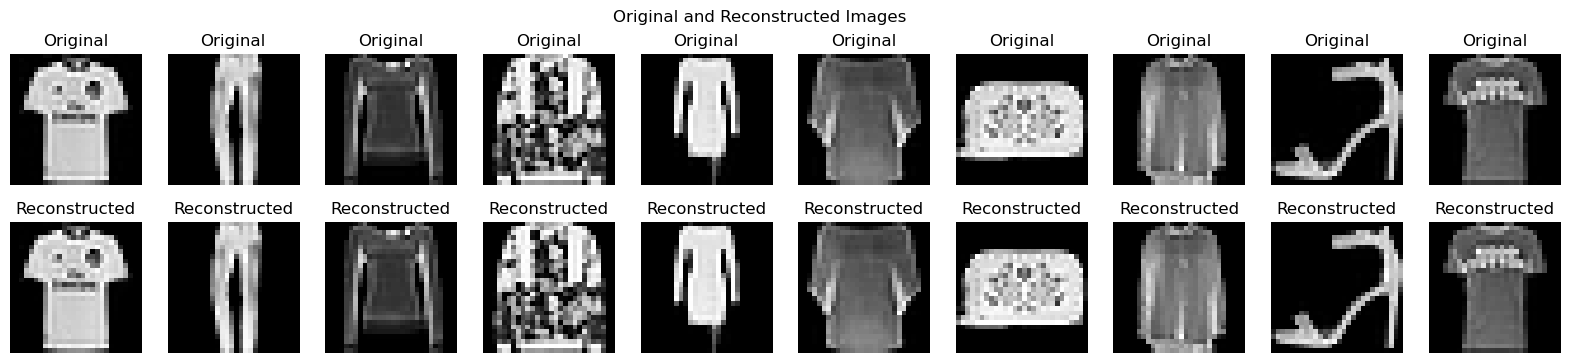

In [ ]:
model = CNN_AE(in_channels=1, channel_list=[8,16,32])  # Customize as needed
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epoch = 10
train_losses,val_losses = fit(model,loss_fn,optimizer,num_epochs=num_epoch,train_loader=train_loader,val_loader=val_loader)
plot_losses('Depth-3',num_epoch=num_epoch,train_losses=train_losses,val_losses=val_losses)

# Run predict and visualize
_, y_pred, y_true = predict(model, loss_fn, test_loader)
visualise_samples(y_true, y_pred, num_samples=10)


Epoch [1/10], Train Loss: 0.0040, Validation Loss: 0.0004
Epoch [2/10], Train Loss: 0.0003, Validation Loss: 0.0002
Epoch [3/10], Train Loss: 0.0002, Validation Loss: 0.0001
Epoch [4/10], Train Loss: 0.0001, Validation Loss: 0.0001
Epoch [5/10], Train Loss: 0.0001, Validation Loss: 0.0001
Epoch [6/10], Train Loss: 0.0001, Validation Loss: 0.0000
Epoch [7/10], Train Loss: 0.0000, Validation Loss: 0.0000
Epoch [8/10], Train Loss: 0.0000, Validation Loss: 0.0000
Epoch [9/10], Train Loss: 0.0000, Validation Loss: 0.0000
Epoch [10/10], Train Loss: 0.0000, Validation Loss: 0.0000


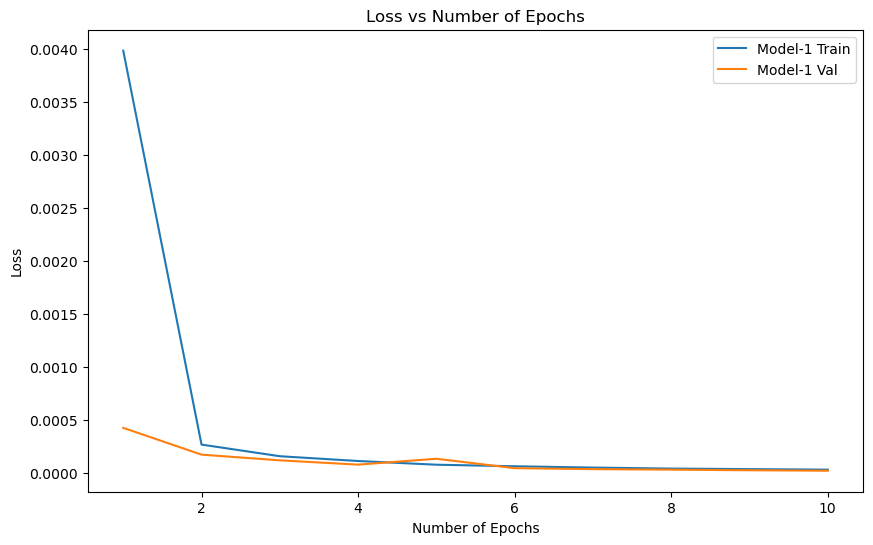

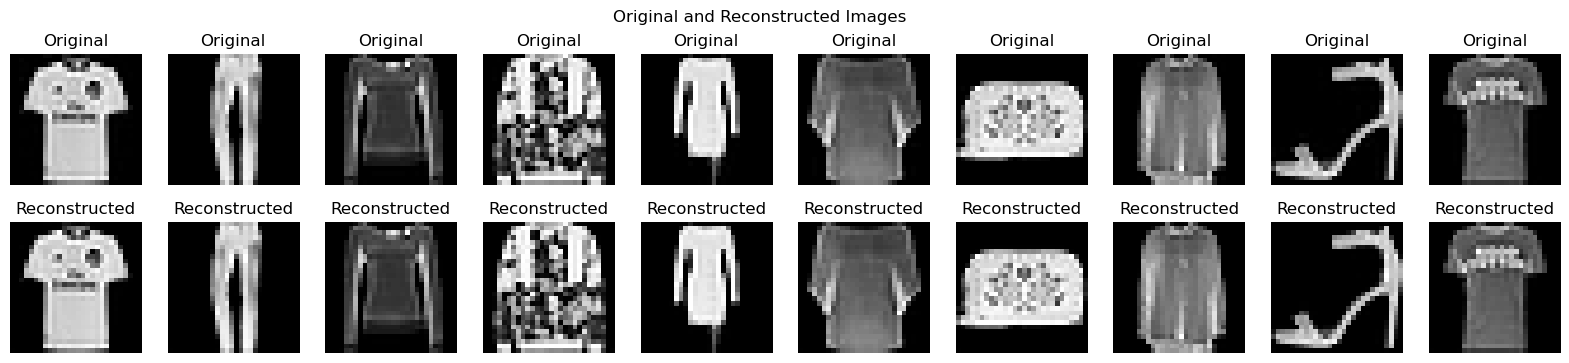

In [12]:
# Best Model : Using CNN-

# Initialize the autoencoder, loss function, and optimizer
model_cnn = CNN_AE(in_channels=1, channel_list=[16,32]).to(device)  # Customize as needed
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)
num_epoch = 10
train_losses,val_losses = fit(model_cnn,loss_fn,optimizer,num_epochs=num_epoch,train_loader=train_loader,val_loader=val_loader)
plot_losses('Model-1',num_epoch=num_epoch,train_losses=train_losses,val_losses=val_losses)

# Run predict and visualize
_, y_pred_cnn, y_true = predict(model_cnn, loss_fn, test_loader)
visualise_samples(y_true, y_pred_cnn, num_samples=10)



### Visualisation in 2d and 3d for CNN Best

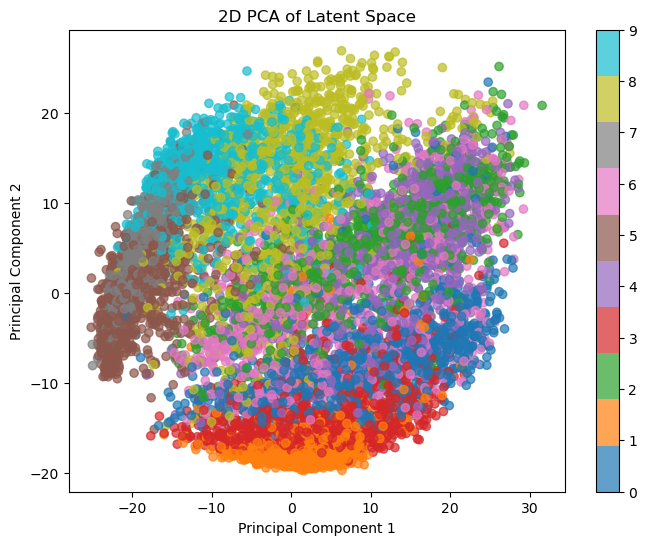

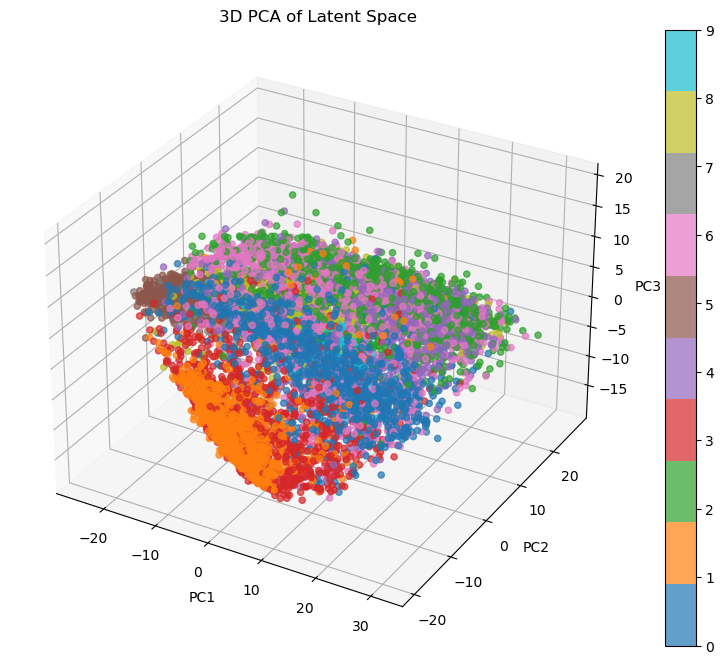

In [ ]:
from sklearn.decomposition import pca_sklearn as pca_sklearn
from mpl_toolkits.mplot3d import Axes3D

# Encode test data
def get_latent_representations(model, loader, device='cpu'):
    model.to(device)
    model.eval()
    latent_representations = []
    labels = []
    with torch.no_grad():
        for data, label in loader:
            data, label = data.to(device), label.to(device)  
            encoded = model.encode(data).view(data.size(0), -1)  
            latent_representations.append(encoded.cpu().numpy())  
            labels.append(label.cpu().numpy())  
    return np.concatenate(latent_representations), np.concatenate(labels)


latent_representations, labels = get_latent_representations(model_cnn, test_loader, device=device)

pca_2d = pca_sklearn(n_components=2)
latent_2d = pca_2d.fit_transform(latent_representations)

pca_3d = pca_sklearn(n_components=3)
latent_3d = pca_3d.fit_transform(latent_representations)


plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA of Latent Space')
plt.show()

# Plot 3D latent space
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(latent_3d[:, 0], latent_3d[:, 1], latent_3d[:, 2], c=labels, cmap='tab10', alpha=0.7)
fig.colorbar(scatter)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('3D PCA of Latent Space')
plt.show()


From the above 2D and 3D representations we can see that there are some clusters appear to form based on color, especially in certain regions of the plot. 
- For example , orange(2D,3D) , blue (3D) , brown(2D) etc.

## Analysis for CNN Autoencoder:
- The best performing model has the following hyper-parameters:
    1) in_channels=1
    2) channel_list=[16,32]
    3) num_epoch = 10
    4) optimizer = Adam
    5) learning_rate = 0.001

- Using optimizer as Adam coudn't find the difference between the performance when the dept is varied.
- So used optimizer as SGD just to find the effect of dept on the model.
- Using the loss as metric to identify the best model, as the dept increases the loss also increased.
- Hence the best model using SGD as optimizer is when depth is one.

Epoch 1, Loss: 1.8107
Epoch 2, Loss: 1.8109
Epoch 3, Loss: 1.8109
Epoch 4, Loss: 1.1832
Epoch 5, Loss: 0.7201
Epoch 6, Loss: 0.4381
Epoch 7, Loss: 0.2953
Epoch 8, Loss: 0.2425
Epoch 9, Loss: 0.2124
Epoch 10, Loss: 0.1914
Epoch 11, Loss: 0.1739
Epoch 12, Loss: 0.1592
Epoch 13, Loss: 0.1435
Epoch 14, Loss: 0.1279
Epoch 15, Loss: 0.1165
Epoch 16, Loss: 0.1043
Epoch 17, Loss: 0.0923
Epoch 18, Loss: 0.0850
Epoch 19, Loss: 0.0797
Epoch 20, Loss: 0.0725
Epoch 21, Loss: 0.0628
Epoch 22, Loss: 0.0566
Epoch 23, Loss: 0.0512
Epoch 24, Loss: 0.0480
Epoch 25, Loss: 0.0416
Epoch 26, Loss: 0.0315
Epoch 27, Loss: 0.0270
Epoch 28, Loss: 0.0246
Epoch 29, Loss: 0.0236
Epoch 30, Loss: 0.0228
Epoch 31, Loss: 0.0224
Epoch 32, Loss: 0.0207
Epoch 33, Loss: 0.0171
Epoch 34, Loss: 0.0140
Epoch 35, Loss: 0.0108
Epoch 36, Loss: 0.0095
Epoch 37, Loss: 0.0106
Epoch 38, Loss: 0.0098
Epoch 39, Loss: 0.0091
Epoch 40, Loss: 0.0087
Epoch 41, Loss: 0.0084
Epoch 42, Loss: 0.0082
Epoch 43, Loss: 0.0081
Epoch 44, Loss: 0.00

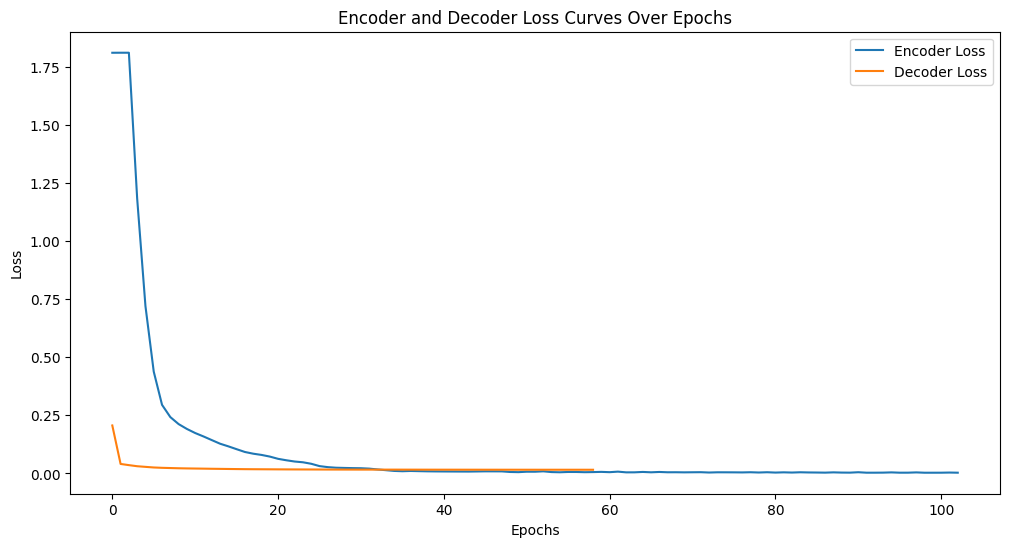

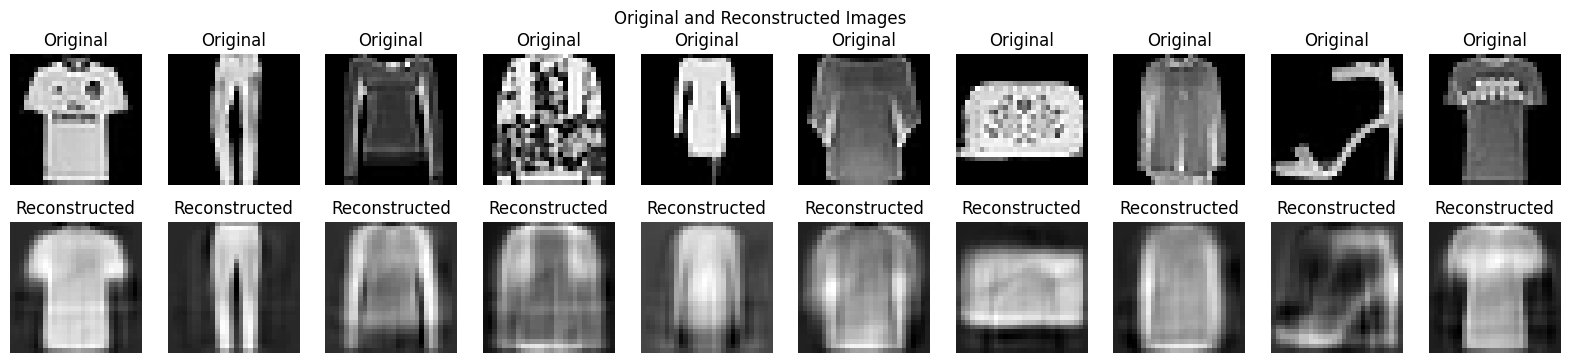

In [ ]:
train_features_flattened = train_features_tensor.view(-1, 28*28)  # Flatten to shape (60000, 784)
val_features_flattened = val_features_tensor.view(-1, 28*28)  # Flatten to shape (10000, 784)

train_features_flattened_np = train_features_flattened.numpy()
val_features_flattened_np = val_features_flattened.numpy()

input_size = train_features_flattened_np.shape[1]  # Should now be 784

MLP_ae = AE(input_size=input_size, reduced_size=31, lr=0.01, num_epoch=125, batch_size=16, act_fn='relu', opt_fn='MBGD')
pc = PCA(n_components=31,X=train_features_flattened_np)
train_red = pc.transform()
pc = PCA(n_components=31,X=val_features_flattened_np)
val_red = pc.transform()



losses_encoder, losses_decoder = MLP_ae.fit(train_features_flattened_np, train_red,
                                                 val_features_flattened_np, val_red)


plt.figure(figsize=(12, 6))
plt.plot(losses_encoder, label="Encoder Loss")
plt.plot(losses_decoder, label="Decoder Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Encoder and Decoder Loss Curves Over Epochs")
plt.legend()
plt.show()



X_test_sample, _ = next(iter(test_loader))
X_test_sample = X_test_sample[:10].view(-1, 28*28)  # Flatten each image to shape (10, 784)
reconstructed_images = MLP_ae.reconstruct(X_test_sample.numpy())


image_shape = (28, 28)

fig, axes = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    axes[0, i].imshow(X_test_sample[i].view(image_shape).detach().numpy(), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title("Original")

    axes[1, i].imshow(reconstructed_images[i].reshape(image_shape), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title("Reconstructed")

plt.suptitle("Original and Reconstructed Images")
plt.show()


### Comparision between MLP and CNN Autoencoder:
- Final Loss using MLP : 0.0158
- Final Loss using best CNN AE : 0

The same can be seen through the plot:<br>
MLP Reconstruction:
![Using MLP](figures/MLP.png)<br><br><br>

CNN  Reconstruction:
![Using CNN](figures/CNN_AE.png)



In [9]:
train_features_flattened = train_features_tensor.view(-1, 28*28)  # Flatten to shape (60000, 784)
val_features_flattened = val_features_tensor.view(-1, 28*28)  # Flatten to shape (10000, 784)

train_features_flattened_np = train_features_flattened.numpy()
val_features_flattened_np = val_features_flattened.numpy()

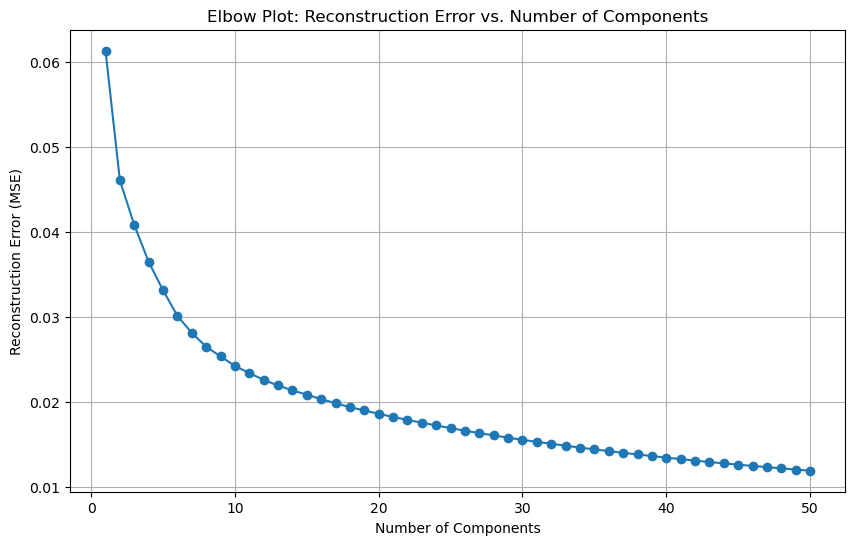

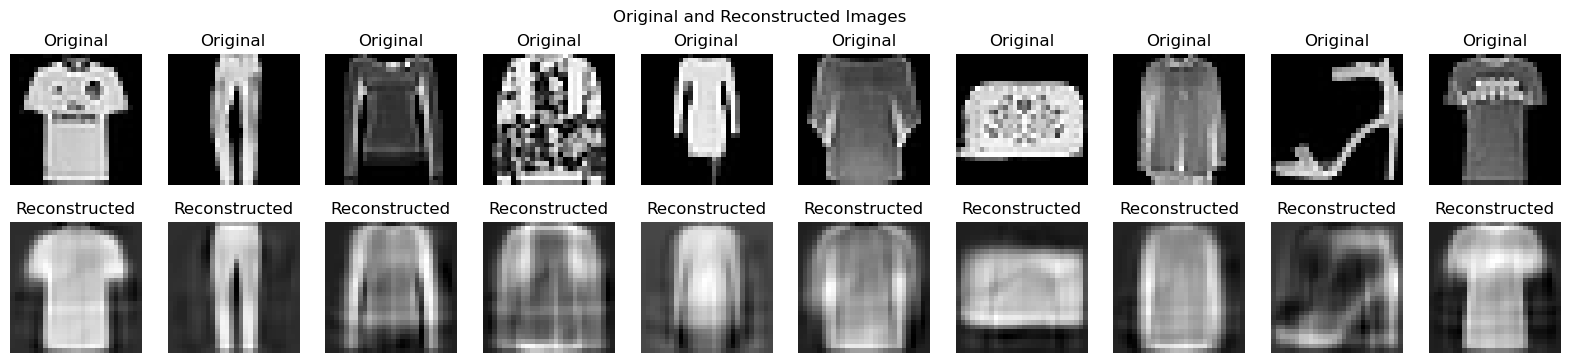

In [10]:
def calculate_reconstruction_error(pca_ae, X, max_components=50):
    errors = []
    for n_components in range(1, max_components + 1):
        reconstructed_X = pca_ae.forward(X, n_components)
        mse = np.mean((X - reconstructed_X) ** 2)
        errors.append(mse)
    return errors

pca_ae = PCA_AE()
pca_ae.fit(train_features_flattened_np)  # Fit PCA on training data

test_features_flattened_np = test_features_tensor.view(-1, 28*28).numpy()
latent_representation = pca_ae.encode(test_features_flattened_np, 31)
reconstructed_images = pca_ae.forward(test_features_flattened_np, 31)

errors = calculate_reconstruction_error(pca_ae, val_features_flattened_np)

# Plotting Reconstruction Error vs. Number of Components
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(errors) + 1), errors, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Reconstruction Error (MSE)")
plt.title("Elbow Plot: Reconstruction Error vs. Number of Components")
plt.grid()
plt.show()

visualise_samples(test_features_flattened_np, reconstructed_images, num_samples=10)


Quality of Reconstruction:<br>
CNN > MLP ~ PCA<br>
CNN has the best reconstruction and MLP,PCA have almost same reconstruction.

K obtained through elbow point is observed to be 31.


In [14]:
k_opt = 31

In [ ]:
def get_latent_features(model, data_loader, output_dim):
    latent_representations = []

    with torch.no_grad():
        sample_batch = next(iter(data_loader))[0].to(device)
        latent_dim = model.encode(sample_batch).view(sample_batch.size(0), -1).size(1)

    linear_mapping = nn.Linear(latent_dim, output_dim).to(device)

    for images, _ in data_loader:
        images = images.to(device)
        latent_rep = model.encode(images) 
        latent_rep = latent_rep.view(latent_rep.size(0), -1)  
        latent_rep = linear_mapping(latent_rep)  
        latent_representations.append(latent_rep.detach().cpu())  

    return torch.cat(latent_representations, dim=0)


def evaluate_knn(train_data, test_data, train_labels, test_labels, k=5):
    knn = KNN(k=k,distance_fn='manhattan')
    predictions = knn.knn_pred(train_data, train_labels,test_data)
    return np.mean(test_labels == predictions)


optimal_dim = 31  


pca_ae.fit(train_features_flattened_np)  
pca_latent_train = pca_ae.encode(train_features_flattened_np, optimal_dim)
pca_latent_test = pca_ae.encode(val_features_flattened_np, optimal_dim)

cnn_latent_train = get_latent_features(model_cnn, train_loader, output_dim=optimal_dim)
cnn_latent_test = get_latent_features(model_cnn, test_loader, output_dim=optimal_dim)


mlp_latent_train = MLP_ae.get_latent(train_features_flattened_np)
mlp_latent_test = MLP_ae.get_latent(val_features_flattened_np)


k_value = 51   # number of neighbours


accuracy_pca = evaluate_knn(pca_latent_train, pca_latent_test, train_labels, test_labels, k=k_value)
print(f"PCA Autoencoder Model Accuracy for k={k_value}: {accuracy_pca * 100:.2f}%")


accuracy_cnn = evaluate_knn(cnn_latent_train, cnn_latent_test, train_labels, test_labels, k=k_value)
print(f"CNN Autoencoder Model Accuracy for k={k_value}: {accuracy_cnn * 100:.2f}%")


accuracy_mlp = evaluate_knn(mlp_latent_train, mlp_latent_test, train_labels, test_labels, k=k_value)
print(f"MLP Autoencoder Model Accuracy for k={k_value}: {accuracy_mlp * 100:.2f}%")




PCA Autoencoder Model Accuracy for k=51: 10.14%
CNN Autoencoder Model Accuracy for k=51: 14.08%
MLP Autoencoder Model Accuracy for k=51: 10.15%


The accuracy using CNN is the highest followed by MLP and then PCA.